## Quora Question Pairs Duplicate Detection

In this project we create an NLP model that detects whether a pair of questions are duplicates based on their meaning.

The task is based on a dataset originally from a Kaggle competition, split into train and test sets in an 80/20 ratio, stratified by the **is_duplicate** label.

The original dataset is available on Kaggle and can be accessed https://www.kaggle.com/c/quora-question-pairs/data.

## Exploratory Data Analysis

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Load the training dataset
df_train = pd.read_csv('/content/quora_question_pairs_train.csv.zip', index_col=0)

In [ ]:
# Load the test dataset
df_test = pd.read_csv('quora_question_pairs_test.csv.zip', index_col=0)

In [ ]:
# Combine training and test datasets for analysis
df=pd.concat([df_train, df_test])
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 404290 entries, 332278 to 7415
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


Dataset contains 404290 rows and 5 columns, combining both the training and test sets. Missing Values: column **question1** has 1 missing value, column **question2** has 2 missing values

**is_duplicate** - target label: 1 if the questions are duplicates (semantically the same), 0 otherwise


In [ ]:
question_ids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [ ]:
# Count total number of unique question IDs
num_unique_ids = question_ids.nunique()

In [ ]:
num_unique_ids

537933

The result shows that there are 537,933 unique question IDs in the combined dataset.

In [ ]:
# Count frequency of each question ID
qid_frequency_df = question_ids.value_counts()

# Count how many question IDs appear more than once
num_repeated_qids = np.sum(qid_frequency_df > 1)

In [ ]:
# Display frequency of each question ID
print(qid_frequency_df)

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
240395      1
328162      1
146147      1
334588      1
14489       1
Name: count, Length: 537933, dtype: int64


In [ ]:
# Calculate the percentage of repeated question IDs
repeated_qid_percentage= (num_repeated_qids / num_unique_ids) * 100

In [ ]:
# Display statistics
print(f"Total number of unique questions: {num_unique_ids}")
print(f"Total number of questions that appear more than one time: {num_repeated_qids} ({round(repeated_qid_percentage, 2)}%)")
print(f"The maximun number of times a single question repeated: {qid_frequency_df.max()}")

Total number of unique questions: 537933
Total number of questions that appear more than one time: 111780 (20.78%)
The maximun number of times a single question repeated: 157


So we can see that around 1 in 5 questions appears in more than one pair. This shows a significant level of overlap, meaning many questions are reused in different contexts.

The most frequently occurring question appears 157 times, which may indicate that some questions are particularly common or broadly phrased.

In [ ]:
# Check frequency distribution in qid1 and qid2 separately
df['qid1'].value_counts()

,count
qid1,
8461,50
14110,48
20628,47
1749,47
25984,47
...,...
129253,1
228668,1
385766,1


In [ ]:
df['qid2'].value_counts()

,count
qid2,
30782,120
2559,115
4044,100
2561,71
17978,66
...,...
486999,1
470835,1
423247,1


We’re examining how often each question ID appears in the qid1 and qid2 columns separately.

qid1:

The most frequent question ID appears 50 times.

The number of unique qid1 entries is 290,654.

qid2:

The most frequent question ID appears 120 times.

The number of unique qid2 entries is 299,364.

There's a notable imbalance between the most frequent qid1 (50) and qid2 (120). This suggests some questions are more frequently reused as the second question in a pair.


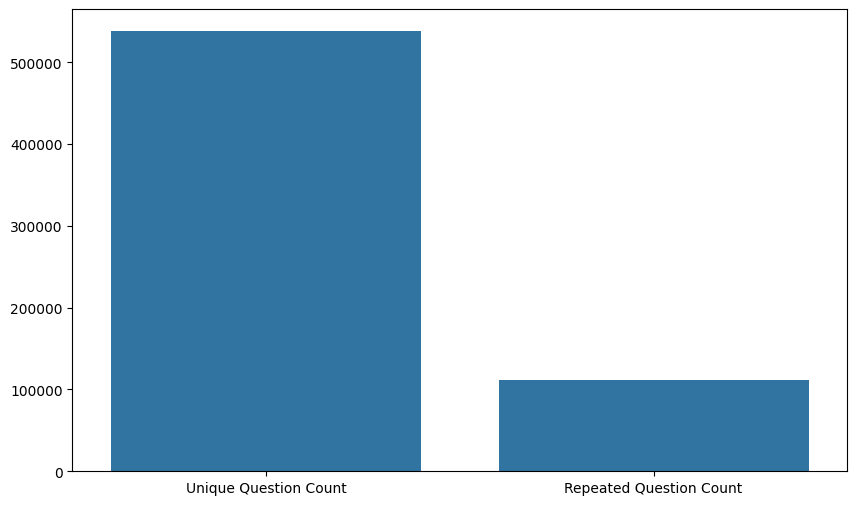

In [ ]:
# Bar plot comparing unique and repeated question counts
x = ["Unique Question Count", "Repeated Question Count"]
y = [num_unique_ids, num_repeated_qids]

plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=y)
plt.show()

The bar chart clearly shows that the majority of questions in the dataset are unique, while a significantly smaller portion appear more than once.

The presence of repeated questions can be valuable for improving model generalization, since some questions occur in different semantic contexts.

However, it's also important to monitor for bias toward overrepresented questions.

In [ ]:
# Count occurrences of each question pair (qid1, qid2)
pair_counts = (
    df[['qid1', 'qid2']]
      .groupby(['qid1', 'qid2'])
      .size()                #
      .reset_index(name='count')
)

# Filter pairs that appear more than once
repeated_pairs = pair_counts[pair_counts['count'] > 1]

# Count total number of duplicate rows (extra appearances)
extra_occurrences = repeated_pairs['count'].sum() - repeated_pairs.shape[0]

print(f"Number of duplicate rows: {extra_occurrences}")


Number of duplicate rows: 0


Every pair of questions (qid1, qid2) appears only once in the dataset.

This confirms that the dataset is clean and free from redundancy in terms of repeated question combinations.

In [ ]:
# Show the pair counts dataframe
pair_counts

,qid1,qid2,count
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1
...,...,...,...
404285,537924,537925,1
404286,537926,537927,1
404287,537928,537929,1
404288,537930,537931,1


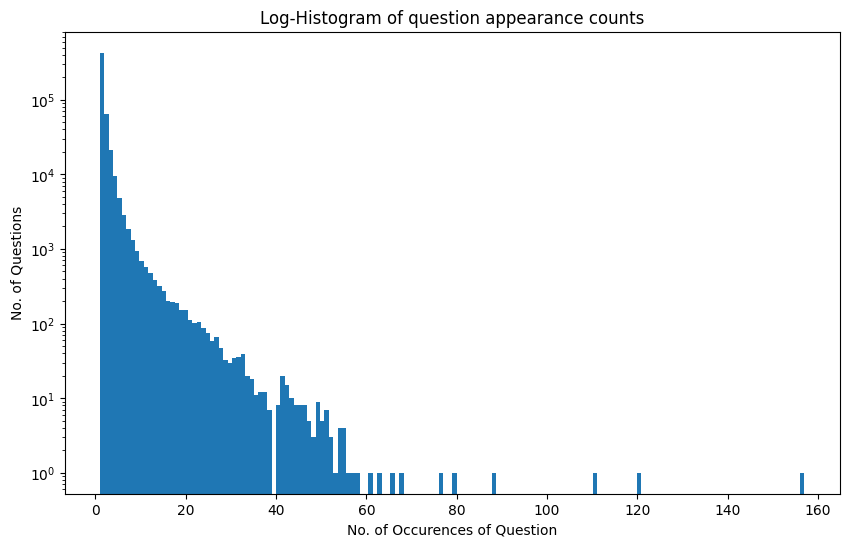

Maximum number of times a single question is repeated: 157


In [ ]:
# Histogram showing how often each question appears, using log scale
plt.figure(figsize=(10, 6))
plt.hist(question_ids.value_counts(), bins=160)
plt.title("Log-Histogram of question appearance counts")
plt.xlabel("No. of Occurences of Question")
plt.ylabel("No. of Questions")
plt.yscale('log')
plt.show()

# Print the maximum frequency of any single question
print(f"Maximum number of times a single question is repeated: {max(question_ids.value_counts())}")

The histogram shows the distribution of how many times each question appears across all pairs.

Most questions in the dataset appear only once or a few times, which means the data is quite diverse.


However, there are a small number of questions that appear very frequently — these can influence the model's learning.

Take a closer look at the training dataset

In [ ]:
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


In [ ]:
# Display general information about the training dataset
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB
None


In [ ]:
# Check for missing values
print(df_train.isnull().sum())

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [ ]:
# Drop rows with missing values
df_train = df_train.dropna()
df_train.shape

(323429, 5)

In [ ]:
# Confirm that missing values have been removed
print(df_train.isnull().sum())

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


We checked for missing values in the training dataset:

question1 had 1 missing value, question2 had 2 missing values, all other columns were complete.

We dropped all rows with any missing values and after removal the dataset now contains 323,429 rows (down from 323,432) and all columns are now fully filled (no NaN values).


In [ ]:
# Analyze the distribution of the target variable (is_duplicate)
target_train_counts = df['is_duplicate'].value_counts()
print(target_train_counts)

is_duplicate
0    255027
1    149263
Name: count, dtype: int64


The dataset is imbalanced, with about 63% non-duplicates and 37% duplicates.

Class imbalance can lead the model to favor the majority class (label 0) and underperform on detecting true duplicates.

It's important to consider balancing strategies like class weighting and
or using metrics like F1-score and AUROC that handle imbalance better.

<ipython-input-25-3ef73ef77759>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_duplicate', data=df_train, palette='Set2')


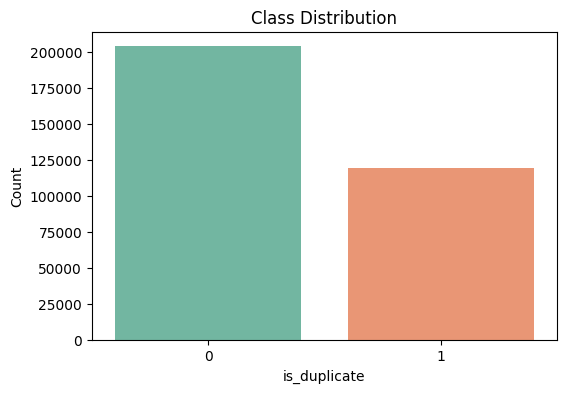

In [ ]:
# Visualize the distribution of duplicate vs. non-duplicate classes
plt.figure(figsize=(6, 4))
sns.countplot(x='is_duplicate', data=df_train, palette='Set2')
plt.title('Class Distribution')
plt.xlabel('is_duplicate')
plt.ylabel('Count')
plt.show()

The bar chart shows the distribution of the target variable is_duplicate, where
class 0 has a significantly higher count than class 1.

In [ ]:
# Class distribution proportions
target_train_counts = df['is_duplicate'].value_counts(normalize=True)
print(target_train_counts)

is_duplicate
0    0.630802
1    0.369198
Name: proportion, dtype: float64


In [ ]:
# Tokenize a sample question using TweetTokenizer

from nltk.tokenize import TweetTokenizer

tt = TweetTokenizer()

In [ ]:
print(tt.tokenize(df_train.loc[122738, 'question2']))

['Why', "don't", 'many', 'people', 'posting', 'questions', 'on', 'Quora', 'check', 'Google', 'first', '?']


In [ ]:
from quora_questions_preprocessing import extract_token_features

Function extract_token_features():

Iinitializes a TweetTokenizer Tokenizes the text into words (keeping alphanumeric tokens only, lowercased).

Creates token columns:

q1_tokens: tokens from question1

q2_tokens: tokens from question2

Computes word-based features:
q1_words, q2_words: total number of words (tokens) in each question

q1_unique_words, q2_unique_words: number of unique words in each question

common_words: number of words shared between both questions

word_share: Jaccard similarity between the word sets of the two questions

unique_word_ratio: ratio of the smaller to larger unique word count

In [ ]:
# Apply the feature extraction to both training and test sets
df_train = extract_token_features(df_train)
df_test = extract_token_features(df_test)

In [ ]:
# Show sample of extracted features
pd.set_option('display.max_colwidth', None)
print(df_train[['question1', 'question2', 'common_words', 'word_share', 'unique_word_ratio','is_duplicate']].sample(5))

                                                    question1  \
id                                                              
247757        If Buddhism is not a religion, then what is it?   
255710                     Why is India adopting GST so late?   
321288  What are the common mistakes made at a job interview?   
87124             How can you delete your Yahoo mail account?   
154874       What led to Cyrus Mistry ouster from TATA GROUP?   

                                                                       question2  \
id                                                                                 
247757                     If Buddha was an atheist, why is Buddhism a religion?   
255710                                    Has GST been implemented in India yet?   
321288  What are some of the most common mistakes people make in job interviews?   
87124                                        How do you disable a Yahoo account?   
154874         What is the reason behind

Data quality check: viewing random samples helps confirm that the token-based features are being computed correctly and aligned with the is_duplicate label.

In [ ]:
# Select relevant feature columns for analysis
features = ['q1_words', 'q2_words', 'q1_unique_words','q2_unique_words', 'common_words', 'word_share', 'unique_word_ratio']

In [ ]:
# Display summary statistics for the selected features
df_train[features].describe().round(2)

,q1_words,q2_words,q1_unique_words,q2_unique_words,common_words,word_share,unique_word_ratio
count,323429.00,323429.00,323429.00,323429.00,323429.00,323429.00,323429.00
mean,10.84,11.08,10.30,10.47,4.88,0.37,0.77
std,5.39,6.23,4.55,5.07,3.07,0.24,0.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.00,7.00,7.00,7.00,3.00,0.18,0.65
50%,10.00,9.00,9.00,9.00,5.00,0.33,0.80
75%,13.00,13.00,12.00,12.00,6.00,0.53,0.90
max,126.00,226.00,92.00,130.00,40.00,1.00,1.00


Кey takeaways from the summary statistics of the extracted features:

Typical question length ranges from 7 to 13 words, with median unique word counts around 9. This suggests that most questions are moderately long and contain relatively low word repetition.

Overlap and similarity: The average number of common words is about 5, and the average word share is 0.37, indicating a modest lexical overlap between question pairs. Some pairs have very high overlap (up to 40 words in common and a word share of 1.0), which are likely duplicates.

The unique_word_ratio has a high mean of 0.77 and median of 0.80, showing that most question pairs have fairly similar levels of vocabulary complexity or diversity.

These insights confirm that the engineered features effectively capture structural and lexical relationships useful for detecting duplicate questions.

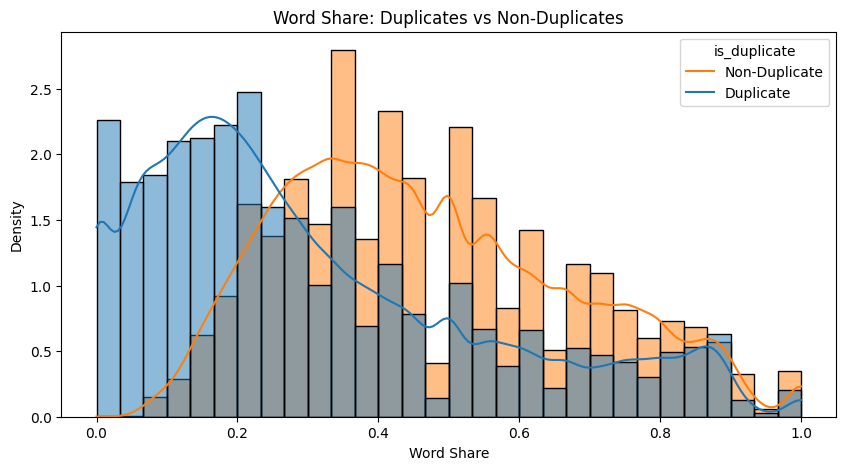

In [ ]:
# Plot distribution of word share for duplicate vs. non-duplicate questions
plt.figure(figsize=(10, 5))
sns.histplot(data=df_train, x='word_share', hue='is_duplicate', bins=30,
             kde=True, stat='density', common_norm=False)
plt.title('Word Share: Duplicates vs Non-Duplicates')
plt.xlabel('Word Share')
plt.ylabel('Density')
plt.legend(title='is_duplicate', labels=['Non-Duplicate', 'Duplicate'])
plt.show()


This graph shows the distribution of the word share feature for duplicate and non-duplicate question pairs.

Duplicate questions (blue) tend to have a higher word share, meaning they share more common words.

Non-duplicates (orange) are more concentrated at lower word share values. The plot illustrates that word share can effectively help differentiate between the two classes.

In [ ]:
# Display first few rows of the processed training set
display(df_train.head(3))

,qid1,qid2,question1,question2,is_duplicate,q1_tokens,q2_tokens,q1_words,q2_words,q1_unique_words,q2_unique_words,common_words,word_share,unique_word_ratio
id,,,,,,,,,,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three independent variables is also independent?,0,"[the, iliad, and, the, odyssey, in, the, greek, culture]","[how, do, i, prove, that, the, pairs, of, three, independent, variables, is, also, independent]",9,14,7,13,1,0.052632,0.538462
196656,297402,297403,What is practical management and what is strategic management?,What are the practical aspects of strategic management?,0,"[what, is, practical, management, and, what, is, strategic, management]","[what, are, the, practical, aspects, of, strategic, management]",9,8,6,8,4,0.400000,0.750000
113125,184949,184950,How useful is MakeUseOf Answers?,"Is there any Q&A site that is not Yahoo answers, where hate speech is allowed?",0,"[how, useful, is, makeuseof, answers]","[is, there, any, q, a, site, that, is, not, yahoo, answers, where, hate, speech, is, allowed]",5,16,5,14,2,0.117647,0.357143


<ipython-input-36-5d18da8fe7a0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_duplicate', y=feature, data=df_train, ax=axes[i], palette='Set1')
<ipython-input-36-5d18da8fe7a0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_duplicate', y=feature, data=df_train, ax=axes[i], palette='Set1')
<ipython-input-36-5d18da8fe7a0>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_duplicate', y=feature, data=df_train, ax=axes[i], palette='Set1')


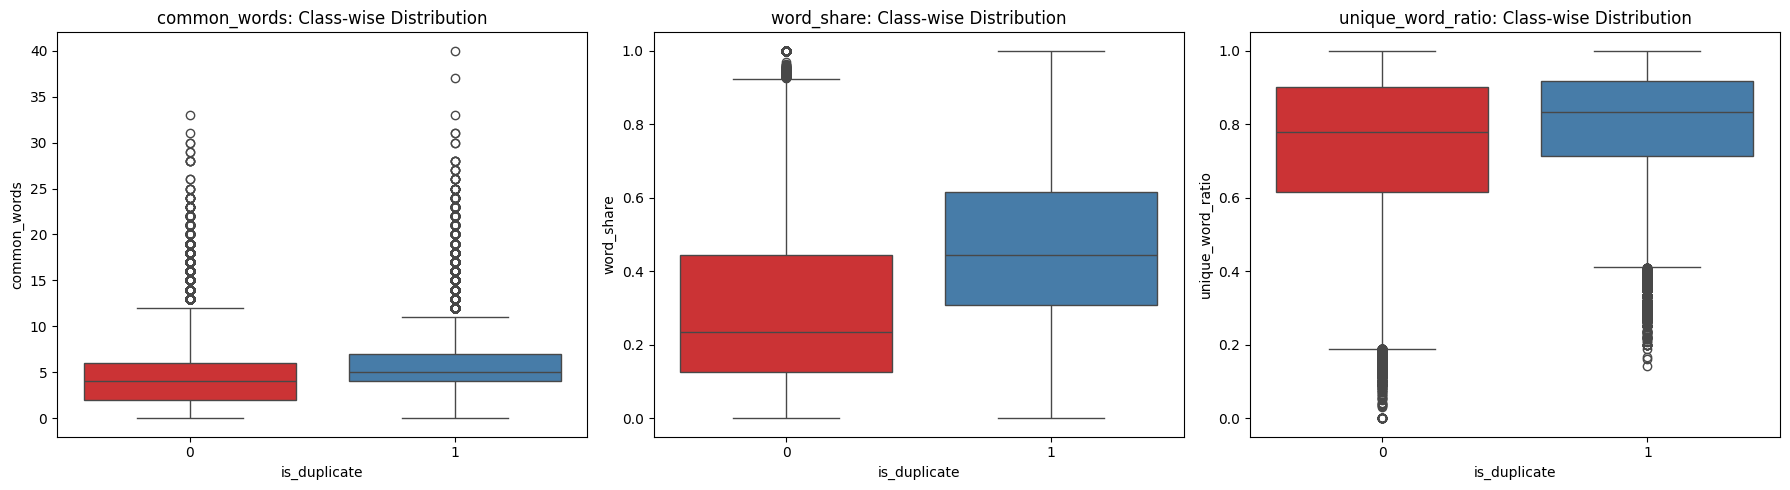

In [ ]:
# Box plots of selected features grouped by the target variable
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ['common_words', 'word_share', 'unique_word_ratio']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features_to_plot):
    sns.boxplot(x='is_duplicate', y=feature, data=df_train, ax=axes[i], palette='Set1')
    axes[i].set_title(f'{feature}: Class-wise Distribution')

plt.tight_layout()
plt.show()

**Common Words:**

Duplicate questions (class 1) tend to have slightly more common words than non-duplicates (class 0).

However, the overlap is considerable, indicating that this feature alone might not be sufficient for strong discrimination.

**Word Share:**

Duplicate pairs show a higher word share (i.e., the proportion of shared words is larger).

The median value for duplicates is significantly higher than for non-duplicates, suggesting that word share is a useful discriminative feature.

**Unique Word Ratio:**

Both classes tend to have high unique word ratios, but duplicates generally maintain a higher ratio.

Non-duplicates display a wider spread with more low outliers, indicating more lexical variation across non-duplicate pairs.

**Conclusion**:
Features like **word share** and **unique word ratio** appear to have a meaningful correlation with the target label and could contribute to model performance.

**Common words** has a weaker separation between classes but may still offer value when combined with other features.

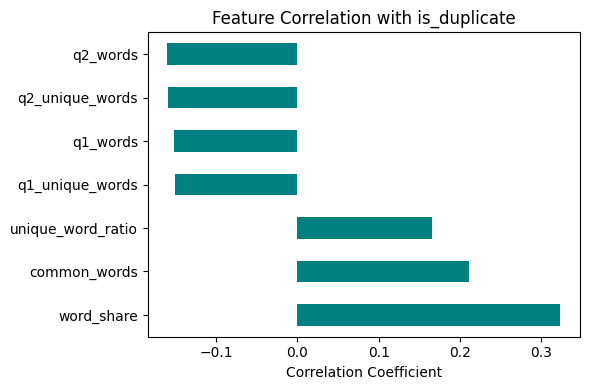

In [ ]:
# Calculate correlation between features and the target variable
corr_with_target = df_train[features] \
    .corrwith(df_train['is_duplicate']) \
    .sort_values(ascending=False)

# Visualize feature correlations with the target
corr_with_target.plot(
    kind='barh',
    figsize=(6, 4),
    color='teal'
)

plt.title('Feature Correlation with is_duplicate')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


In [ ]:
# Print sorted correlation values
print(corr_with_target.sort_values(ascending=False))

word_share           0.323377
common_words         0.211079
unique_word_ratio    0.165587
q1_unique_words     -0.150525
q1_words            -0.152130
q2_unique_words     -0.158930
q2_words            -0.159965
dtype: float64


The bar chart illustrates the Pearson correlation coefficients between various engineered features and the target variable is_duplicate.

Strongest Positive Correlations:

word_share (0.32) has the highest positive correlation with duplicate labels, suggesting that the greater the proportion of shared words between two questions, the more likely they are duplicates.

common_words (0.21) also correlates positively, meaning duplicates tend to share more exact word matches.

Moderate Correlation:

unique_word_ratio (0.17) shows a moderate positive relationship — indicating that questions with a higher proportion of unique words (relative to total words) are slightly more likely to be duplicates.

Negative Correlations:

Features related to individual question lengths (q1_words, q2_words, q1_unique_words, q2_unique_words) show weak negative correlations (around -0.15), implying that longer or more complex individual questions are slightly less likely to be duplicates — though this relationship is weak.

We conducted an exploratory analysis and engineered several textual features to help distinguish duplicate question pairs. Among them, word_share and common_words demonstrated the strongest correlation with the target variable, making them particularly informative for identifying duplicates. While individual question lengths (q1_words, q2_words, etc.) showed weaker predictive power, they may still contribute to model performance when used in combination with other features. These engineered features will be incorporated into future machine learning models, including ensemble and stacked approaches, to enhance predictive accuracy.